In [1]:
import numpy as np
def entropy(p):
    return -p*np.log2(p) - (1-p)*np.log2(1-p)

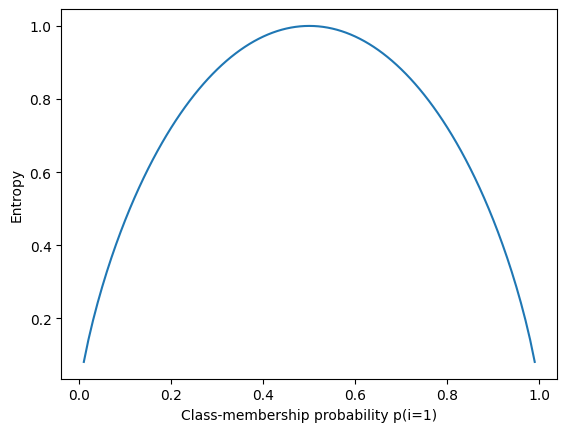

In [2]:
import matplotlib.pyplot as plt 
x = np.arange(0.0,1.0,0.01)
ent = [entropy(p) if p !=0 else None for p in x]
plt.ylabel('Entropy')
plt.xlabel('Class-membership probability p(i=1)')
plt.plot(x,ent)
plt.show()

/var/folders/m1/m54k9pbj7hbcvckx27dplr840000gn/T/ipykernel_8122/1329868547.py:29: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


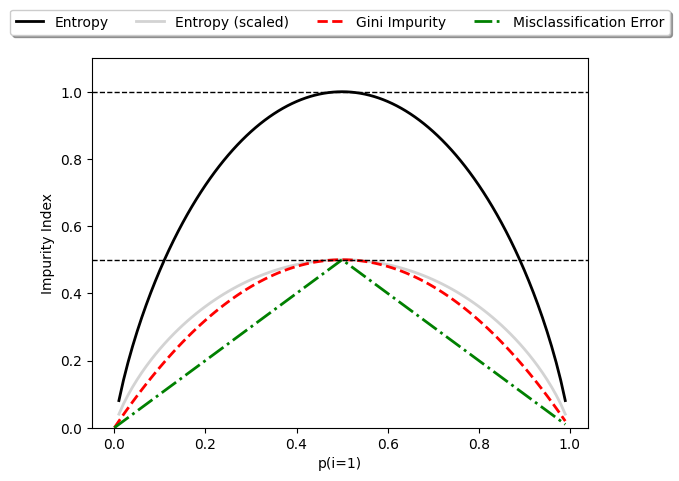

In [6]:
import matplotlib.pyplot as plt 
import numpy as np 
def gini(p):
    return p*(1-p) + (1-p)*(1-(1-p))

def entropy(p):
    return -p*np.log2(p) - (1-p)*np.log2(1-p)

def error(p):
    return 1 - max([p,1-p])

x = np.arange(0.0,1.0,0.01)
ent = [entropy(p) if p !=0 else None for p in x]
sc_ent = [e*0.5 if e else None for e in ent]
err = [error(i) for i in x]
fig = plt.figure()
ax = plt.subplot(111)
for i,lab,ls,c in zip([ent,sc_ent,gini(x),err],
                    ['Entropy','Entropy (scaled)','Gini Impurity','Misclassification Error'],
                    ['-','-','--','-.'],
                    ['black','lightgray','red','green','cyan']):
    line = ax.plot(x,i,label=lab,linewidth=2,linestyle=ls,color=c)
ax.legend(loc='upper center',bbox_to_anchor=(0.5,1.15),ncol=5,fancybox=True,shadow=True)
ax.axhline(y=0.5,linewidth=1,color='k',linestyle='--')
ax.axhline(y=1.0,linewidth=1,color='k',linestyle='--')
plt.ylim([0,1.1])
plt.xlabel('p(i=1)')
plt.ylabel('Impurity Index')
fig.show()

# BUILDING A DECISION TREE

- Decision Trees can be build complex decision boundaries by deviding the feature space into rectangles.
- feature scaling is not requirment for decision tree algorithms.

In [7]:
from sklearn import datasets
import numpy as np

In [8]:
# load iris dataset
iris = datasets.load_iris()
print(dir(iris))
print('Feature Names:', iris.feature_names)
print('Target Names:', iris.target_names)
print('Data Shape:', iris.data.shape)
print('Target Shape:', iris.target.shape)
print('Data:', iris.data)
print('Target:', iris.target)

['DESCR', 'data', 'data_module', 'feature_names', 'filename', 'frame', 'target', 'target_names']
Feature Names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Target Names: ['setosa' 'versicolor' 'virginica']
Data Shape: (150, 4)
Target Shape: (150,)
Data: [[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]
 [5.4 3.9 1.7 0.4]
 [4.6 3.4 1.4 0.3]
 [5.  3.4 1.5 0.2]
 [4.4 2.9 1.4 0.2]
 [4.9 3.1 1.5 0.1]
 [5.4 3.7 1.5 0.2]
 [4.8 3.4 1.6 0.2]
 [4.8 3.  1.4 0.1]
 [4.3 3.  1.1 0.1]
 [5.8 4.  1.2 0.2]
 [5.7 4.4 1.5 0.4]
 [5.4 3.9 1.3 0.4]
 [5.1 3.5 1.4 0.3]
 [5.7 3.8 1.7 0.3]
 [5.1 3.8 1.5 0.3]
 [5.4 3.4 1.7 0.2]
 [5.1 3.7 1.5 0.4]
 [4.6 3.6 1.  0.2]
 [5.1 3.3 1.7 0.5]
 [4.8 3.4 1.9 0.2]
 [5.  3.  1.6 0.2]
 [5.  3.4 1.6 0.4]
 [5.2 3.5 1.5 0.2]
 [5.2 3.4 1.4 0.2]
 [4.7 3.2 1.6 0.2]
 [4.8 3.1 1.6 0.2]
 [5.4 3.4 1.5 0.4]
 [5.2 4.1 1.5 0.1]
 [5.5 4.2 1.4 0.2]
 [4.9 3.1 1.5 0.2]
 [5.  3.2 1.2 0.2]
 [5.5 3.5 1.3 0.2]
 [4.

In [9]:

X = iris.data[:, [2, 3]]
y = iris.target
print('Class labels:',np.unique(y))

Class labels: [0 1 2]


In [10]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)
print('Labels counts in y:', np.bincount(y))
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_test:', np.bincount(y_test))

Labels counts in y: [50 50 50]
Labels counts in y_train: [35 35 35]
Labels counts in y_test: [15 15 15]


In [11]:
# Scaling data
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# sc.fit(X_train)
# X_train_std = sc.transform(X_train)
# X_test_std = sc.transform(X_test)

In [12]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# To check recent matplotlib compatibility
import matplotlib
from distutils.version import LooseVersion


def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=f'Class {cl}', 
                    edgecolor='black')

    # highlight test examples
    if test_idx:
        # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='none',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='Test set')  

In [13]:
#X_combined_std = np.vstack((X_train_std,X_test_std))
#y_combined = np.hstack((y_train,y_test))

In [14]:
from sklearn.tree import DecisionTreeClassifier

In [15]:
tree_model = DecisionTreeClassifier(criterion='gini',max_depth=4,random_state=1)
tree_model.fit(X_train,y_train)
X_combined = np.vstack((X_train,X_test))
y_combined = np.hstack((y_train,y_test))

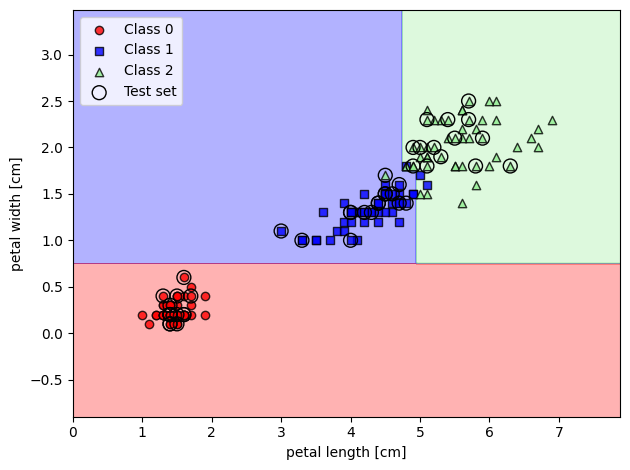

In [17]:
plot_decision_regions(X_combined,y_combined,classifier=tree_model,test_idx=range(105,150))
plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [18]:
from sklearn import tree

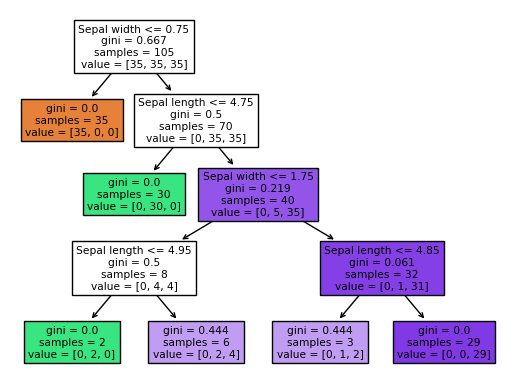

In [19]:
feature_names = ['Sepal length','Sepal width','Petal length','Petal width']

tree.plot_tree(tree_model,filled=True,feature_names=feature_names)
plt.show()

In [20]:
tree_model_2 = DecisionTreeClassifier(criterion='gini',max_depth=3,random_state=1)
tree_model_2.fit(X_train,y_train)
X_combined = np.vstack((X_train,X_test))
y_combined = np.hstack((y_train,y_test))

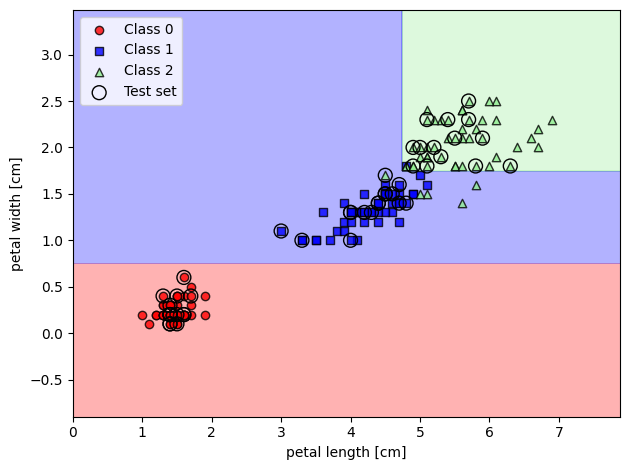

In [21]:
plot_decision_regions(X_combined,y_combined,classifier=tree_model_2,test_idx=range(105,150))
plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

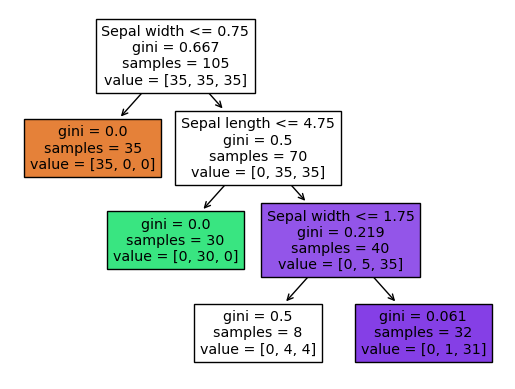

In [22]:
feature_names = ['Sepal length','Sepal width','Petal length','Petal width']

tree.plot_tree(tree_model_2,filled=True,feature_names=feature_names)
plt.show()